__Author: Стурейко Игорь__

__Project: Geekbrains.NeutralNets__

__Lesson 5 - recurent neural network - LSTM architecture__

__Date: 2021-12-19__

## Задание
1. Попробуйте обучить нейронную сеть LSTM на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний).
2. Опишите, какой результата вы получили? Что помогло вам улучшить ее точность?
3. Попробуйте на numpy реализовать нейронную сеть архитектуры LSTM

# Импорты

In [1]:
# Рисовать графики сразу же
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

import os
import datetime

%load_ext tensorboard

# Загрузка данных

In [2]:
df = pd.read_csv('airline-passengers.csv')
df.index = df.Month
df.drop(['Month'], axis=1, inplace=True)
df.shape

(144, 1)

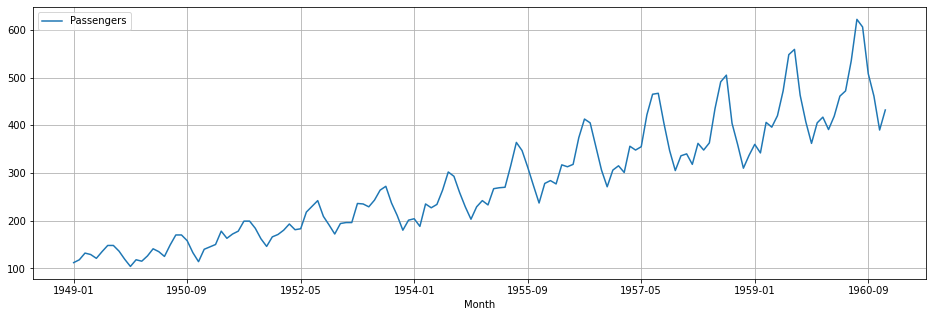

In [3]:
df.plot( figsize = (16,5))

plt.grid('On')
plt.show()

In [12]:
data = df.copy() # берем все что есть
train_split = 100
scaler = StandardScaler()
data_v = scaler.fit_transform(data)
data_f = pd.DataFrame(data_v)

## Создаем данные для обучения

In [47]:
# список признаков, по которым будем учить
channelIndexes = [0]

# длина теста
valLen = 30
# длина истории для работы
xLen = 12
# отступ тестов от тренировок
bias = 2

# вычисляем точку разделения ряда на тесты и тренировку
# train_split = data_f.shape[0] - valLen - bias
# делим
train_data = data_f.iloc[0 : train_split , channelIndexes]
val_data = data_f.iloc[train_split+bias:, channelIndexes]

In [48]:
data_f.shape

(144, 1)

In [49]:
train_data.shape

(100, 1)

In [50]:
val_data.shape

(42, 1)

## Параметры выборки

In [52]:
# шаг по данным для построения обучающих примеров
step = 1

# длина прошлого 
past = xLen
p = past
# горизонт предсказания
future = 1
h=future

# параметры модели для обучения
learning_rate = 0.001
batch_size = 24
epochs = 100

## Выделяем части на обучение и проверку

In [53]:
Chanel_numb = len(channelIndexes)

start = xLen + future
end = start + train_split-1

xTrain_df = train_data.iloc[:-future-xLen+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
xTrain = xTrain_df[[train_data.columns[i] for i in range(Chanel_numb)]].values
yTrain = train_data.iloc[future+xLen-1:,0].values  # сдвиг по времени для предсказания (начать чуть позднее)

sequence_length = int(xLen / step)


x_end = len(val_data) - xLen - future 

label_start = len(train_data)+bias+xLen + future +1

xVal_df = val_data.iloc[:-future-xLen+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
xVal = xVal_df[[val_data.columns[i] for i in range(Chanel_numb)]].values
yVal = val_data.iloc[future+xLen-1:,0].values  # сдвиг по времени для предсказания (начать чуть позднее)

In [54]:
print(xTrain.shape)

print(yTrain.shape)


print(xVal.shape)

print(yVal.shape)

(88, 1)
(88,)
(30, 1)
(30,)


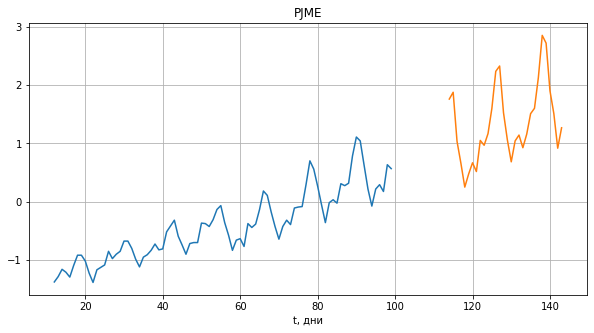

In [55]:
plt.figure(figsize=(10,5))
plt.plot(data_f.index[xLen:yTrain.shape[0]+xLen],yTrain[:])
plt.plot(data_f.index[yTrain.shape[0]+bias+future+2*xLen-1:],yVal[:])
plt.grid('on')
plt.xlabel('t, дни')

plt.title('PJME')
plt.show()

# Обучение

## Создаем пакеты для обучения

In [56]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    xTrain,
    yTrain,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    xVal,
    yVal,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)

In [57]:
for batch in dataset_val.take(2):
    inputs, targets = batch

print('Val dataset')
print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Val dataset
Input shape: (19, 12, 1)
Target shape: (19,)


In [58]:
for batch in dataset_train.take(2):
    inputs, targets = batch

print('Train dataset')
print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Train dataset
Input shape: (24, 12, 1)
Target shape: (24,)


## LSTM model

Epoch 1/100
4/4 [==============================] - 5s 386ms/step - loss: 0.4610 - mae: 0.5583 - val_loss: 1.0615 - val_mae: 0.8664
Epoch 2/100
4/4 [==============================] - 0s 76ms/step - loss: 0.1245 - mae: 0.2861 - val_loss: 0.6614 - val_mae: 0.6236
Epoch 3/100
4/4 [==============================] - 0s 79ms/step - loss: 0.1163 - mae: 0.2655 - val_loss: 0.6658 - val_mae: 0.6255
Epoch 4/100
4/4 [==============================] - 0s 76ms/step - loss: 0.0646 - mae: 0.1915 - val_loss: 0.7028 - val_mae: 0.6481
Epoch 5/100
4/4 [==============================] - 0s 73ms/step - loss: 0.0817 - mae: 0.2309 - val_loss: 0.6054 - val_mae: 0.5904
Epoch 6/100
4/4 [==============================] - 0s 77ms/step - loss: 0.0741 - mae: 0.2160 - val_loss: 0.4528 - val_mae: 0.4934
Epoch 7/100
4/4 [==============================] - 0s 73ms/step - loss: 0.0601 - mae: 0.1814 - val_loss: 0.3683 - val_mae: 0.4381
Epoch 8/100
4/4 [==============================] - 0s 72ms/step - loss: 0.0621 - mae: 0.1

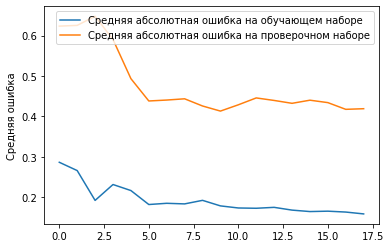

In [59]:
# logs and history
logdir = os.path.join("logs2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard( logdir, histogram_freq=1)

callbaсk = EarlyStopping(monitor='val_mae', patience=8)

model = Sequential()

model.add(LSTM(64, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
model.add(LSTM(64, return_sequences="True")) # <None, 3,32>
model.add(Conv1D(64, 3, activation="linear")) #(None,3,64)
#model.add(Conv1D(64, 1, activation="linear"))
model.add(Flatten())                          # (None, 3*64)
model.add(Dense(3, activation="linear"))      # (None,3)

model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="adam", metrics=['mae'])

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[callbaсk, tensorboard_callback])


plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

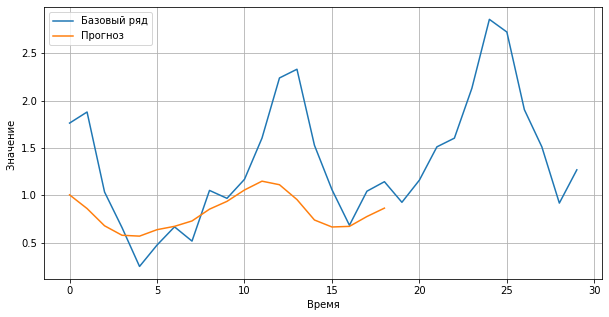

In [67]:
pred = model.predict(dataset_train).flatten()
predVal = model.predict(dataset_val).flatten()

# start = 2
# step = 1
plt.figure(figsize=(10,5))
plt.grid('on')
# plt.plot(predVal[start:start+step], 
#          label='Прогноз')
# plt.plot(yVal.flatten()[start:start+step], 
#          label='Базовый ряд')

plt.plot(yVal.flatten(), 
         label='Базовый ряд')
plt.plot(predVal, 
         label='Прогноз')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

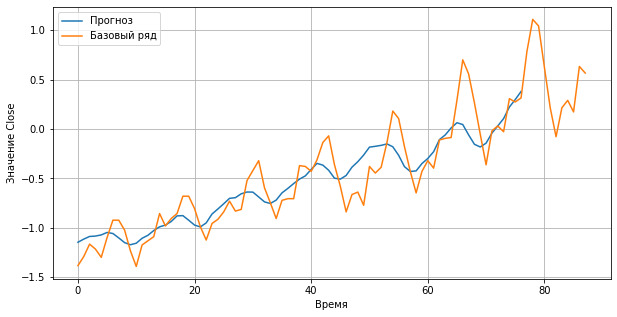

In [68]:
start = 0


plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(pred[start:train_split], 
         label='Прогноз')
plt.plot(yTrain.flatten()[start:train_split], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение Close')
plt.legend()
plt.show()

In [69]:
def correlate(a, b):
  ma = a.mean()
  mb = b.mean()
  mab = (a*b).mean()
  sa = a.std()
  sb = b.std()
  
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

In [70]:
yVal.shape

(30,)

In [72]:
predVal.shape

(19,)

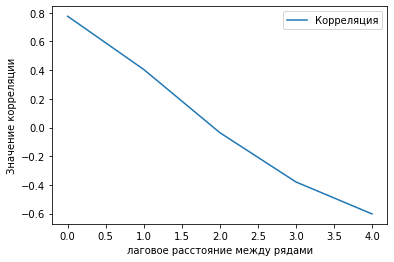

In [73]:
corr = []
start = 0 # начальная точка для проверки корреляций рядов
step = 15 # число точек для проверки корреляций рядов
h=0
yLen = yVal.shape[0]
# yValF = yVal[start:start+step].flatten() # ряд истиных значений
# yPredVal = predVal[start:start+step] # ряд предсказаний 
yValF = yVal[start:start+step].flatten() # ряд истиных значений
yPredVal = predVal[start:start+step] # ряд предсказаний 
# смотрим лаговые корреляции yValF[:-i], yPredVal[i:] для лагов от 0 до 5
for i in range(5):
  corr.append(correlate(yValF[:-1-i], yPredVal[i:-1]))
  
plt.plot(corr, 
         label='Корреляция')
plt.xlabel('лаговое расстояние между рядами')
plt.ylabel('Значение корреляции')
plt.legend()
plt.show()